# Import Library

In [1]:
import os
from google.colab import files

import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import ImageFile

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from sklearn.metrics import confusion_matrix, classification_report


# Make Dataframe

In [4]:
def define_paths(dir):
    files_path = []
    classes = []
    folders = os.listdir(dir)
    for folder in folders:
        folder_path = os.path.join(dir, folder)
        file_list = os.listdir(folder_path)
        for file_name in file_list:
            fpath = os.path.join(folder_path, file_name)
            files_path.append(fpath)
            classes.append(folder)
    return files_path, classes

def define_df(files, classes):
    file_series = pd.Series(files, name= 'file_paths')
    class_series = pd.Series(classes, name='class')
    return pd.concat([file_series, class_series], axis= 1)

def make_df(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    return df

In [5]:
train_dir = '/content/images/tomato/train'
valid_dir = '/content/images/tomato/val'

temp_df = make_df(train_dir)
test_df = make_df(valid_dir)

train_df, valid_df = train_test_split(temp_df, train_size=0.9, shuffle=True, random_state=42, stratify=temp_df['class'])

In [6]:
print(train_df.groupby(['class']).count())
print('Train set minimum class count : ', train_df.groupby(['class']).count().min())
print(valid_df.groupby(['class']).count())
print('Validation set minimum class count:', valid_df.groupby(['class']).count().min())
print(test_df.groupby(['class']).count())
print('Test set minimum class count:', test_df.groupby(['class']).count().min())

                                               file_paths
class                                                    
Tomato___Bacterial_spot                               900
Tomato___Early_blight                                 900
Tomato___Late_blight                                  900
Tomato___Leaf_Mold                                    900
Tomato___Septoria_leaf_spot                           900
Tomato___Spider_mites Two-spotted_spider_mite         900
Tomato___Target_Spot                                  900
Tomato___Tomato_Yellow_Leaf_Curl_Virus                900
Tomato___Tomato_mosaic_virus                          900
Tomato___healthy                                      900
Train set minimum class count :  file_paths    900
dtype: int64
                                               file_paths
class                                                    
Tomato___Bacterial_spot                               100
Tomato___Early_blight                                 100
Tomato__

# Image data generator

In [7]:
img_size = (224, 224)
batch = 40
ts_len = len(test_df)
test_batch = max(sorted([ts_len // n for n in range(1, ts_len + 1) if ts_len%n == 0 and ts_len/n <= 80]))

tr_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip= True)

ts_and_vl_datagen = ImageDataGenerator(rescale=1./255)
print('For train')
train_generator = tr_datagen.flow_from_dataframe(
    train_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=batch,
    shuffle=True,
    class_mode='categorical')

print('\nFor validation')
validation_generator = ts_and_vl_datagen.flow_from_dataframe(
    valid_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=batch,
    shuffle=False,
    class_mode='categorical')

print('\nFor test')
test_generator = ts_and_vl_datagen.flow_from_dataframe(
    test_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=test_batch,
    shuffle=False,
    class_mode='categorical')

For train
Found 9000 validated image filenames belonging to 10 classes.

For validation
Found 1000 validated image filenames belonging to 10 classes.

For test
Found 1000 validated image filenames belonging to 10 classes.


We use `test_batch = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))` so that we will go through all the sample in the test dataset exactly once.

# Plot Image Sample

In [8]:
def show_sample_images(generator, num_sample=30):
    class_list = list(generator.class_indices.keys())
    images, labels = next(generator)
    plt.figure(figsize= (25, 15))
    length = len(labels)
    sample = min(length, 30)
    for i in range(sample):
        plt.subplot(5, 6, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = class_list[index]
        plt.title(class_name, color= 'green', fontsize= 14)
        plt.axis('off')
    plt.show()

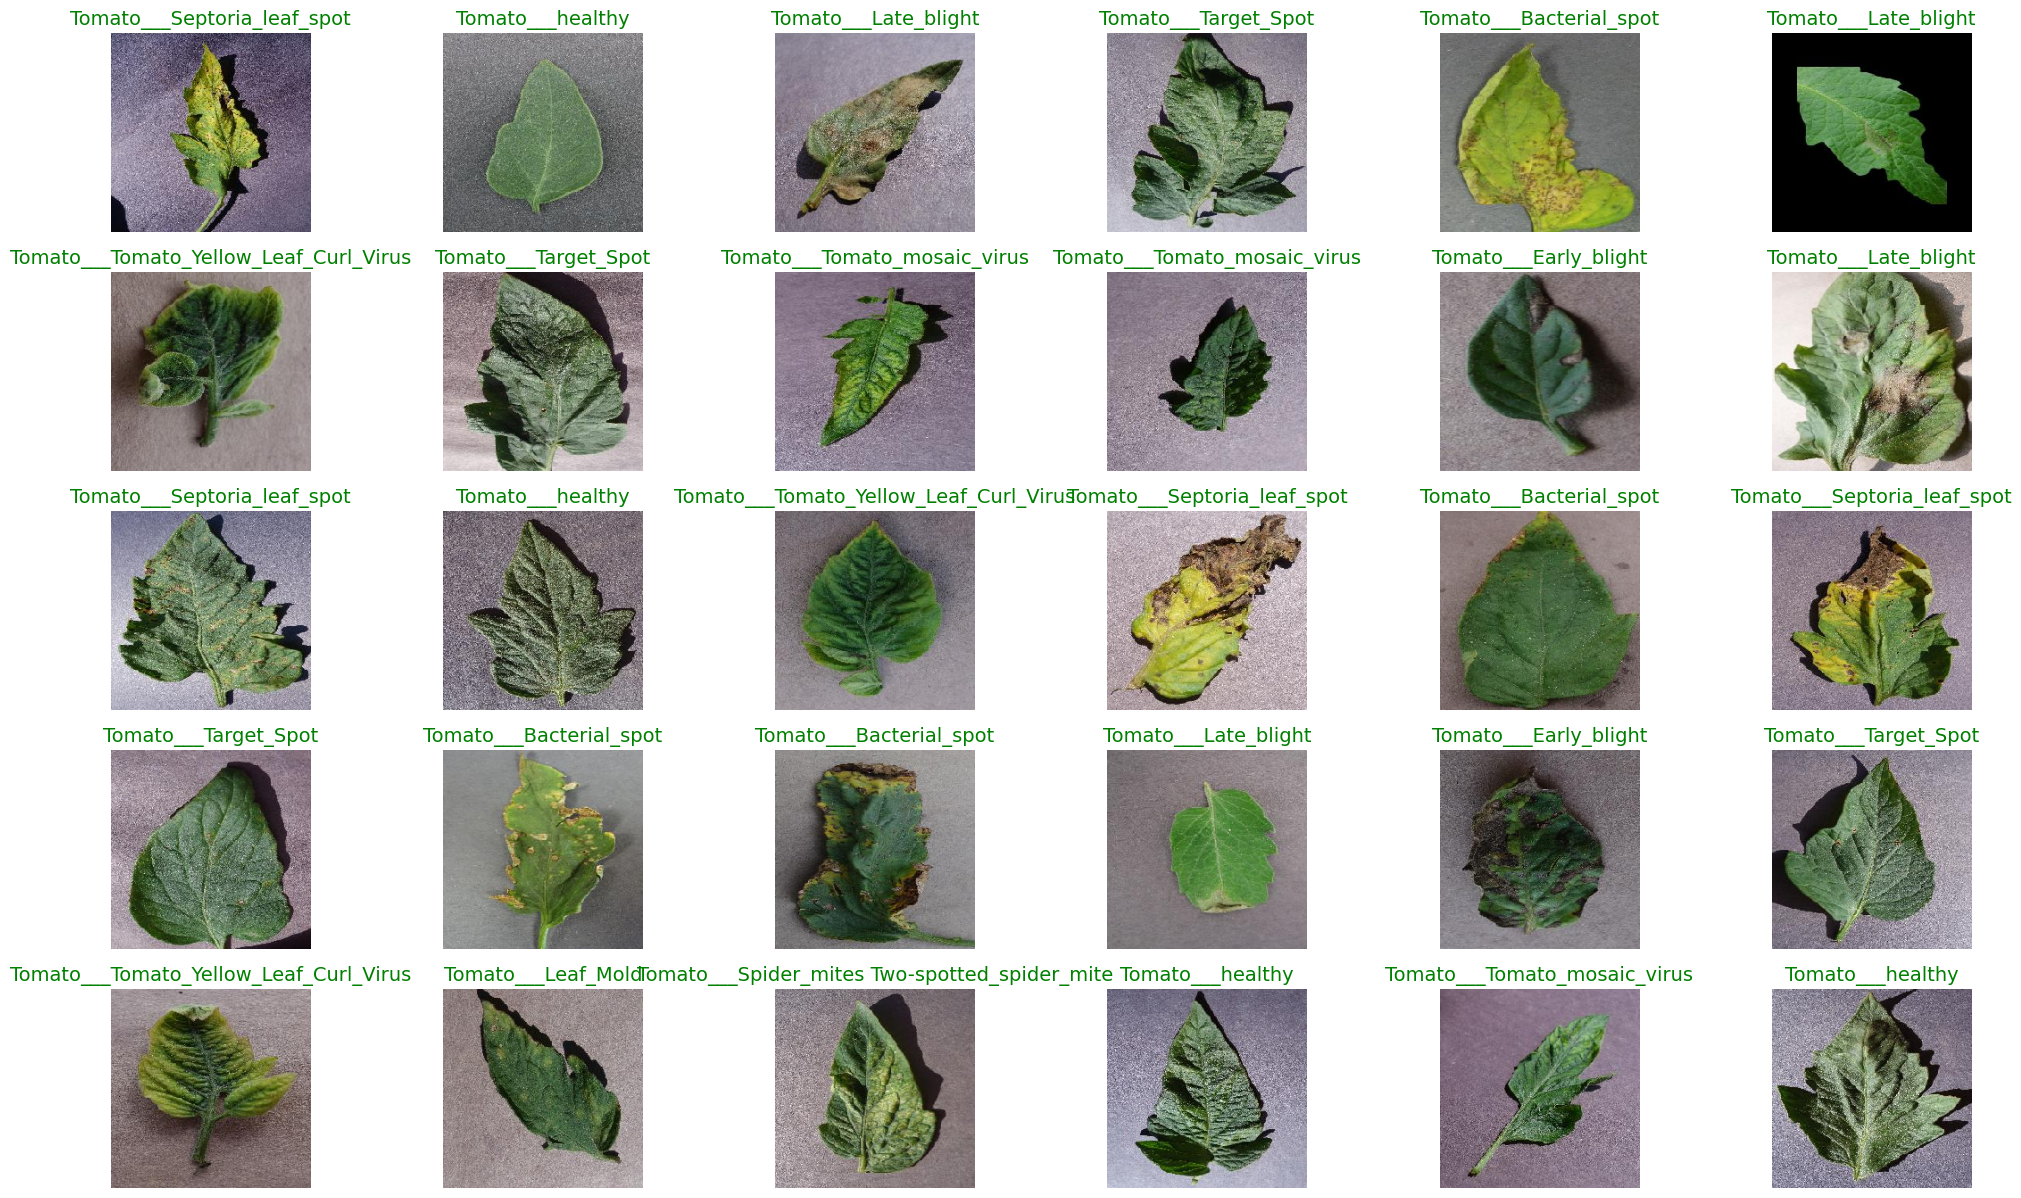

In [9]:
show_sample_images(train_generator)

# Create Model

In [10]:
def create_model(transfer_model):
    img_shape = (224, 224, 3)
    class_num = len(list(train_generator.class_indices.keys()))
    if (transfer_model == "DenseNet201"):
      base_model = DenseNet201(include_top= False, weights= "imagenet", input_shape= img_shape)
    elif (transfer_model == "Xception"):
      base_model = Xception(include_top= False, weights= "imagenet", input_shape= img_shape)
    elif (transfer_model == "MobileNetV2"):
      base_model = MobileNetV2(include_top= False, weights= "imagenet", input_shape= img_shape)
    else:
      base_model = VGG16(include_top= False, weights= "imagenet", input_shape= img_shape)

    base_model.trainable = False

    model = Sequential([
      base_model,
      GlobalAveragePooling2D(),
      Dense(256,
            kernel_regularizer=regularizers.L2(0.015),
            activity_regularizer= regularizers.L1(0.005),
            bias_regularizer= regularizers.L1(0.005),
            activation= 'relu'),
      Dropout(rate= 0.4, seed= 123),
      Dense(class_num, activation= 'softmax')
    ])

    return model


## MobileNetV2 Model

In [11]:
mobilenet = create_model("MobileNetV2")
mobilenet.compile(optimizer="adam", loss= 'categorical_crossentropy', metrics= ['accuracy'])

mobilenet.summary()
mobilenet.layers[0].summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                           

# Custom Callback

In [12]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.97):
            print("\nAccuracy has reached 97%!")
            self.model.stop_training = True

my_callbacks = MyCallback()

# Train Model

Run code below so that no truncated images error while train the models

In [13]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

## MobileNetV2 Training

In [14]:
initial_epochs = 30
history_mobilenet = mobilenet.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=initial_epochs,
    verbose=2,
    callbacks=[my_callbacks],
    validation_steps= None,
    shuffle= False,
)

Epoch 1/30
225/225 - 41s - loss: 2.9370 - accuracy: 0.7038 - val_loss: 1.3344 - val_accuracy: 0.8400 - 41s/epoch - 183ms/step
Epoch 2/30
225/225 - 21s - loss: 1.2345 - accuracy: 0.8021 - val_loss: 0.9968 - val_accuracy: 0.8590 - 21s/epoch - 95ms/step
Epoch 3/30
225/225 - 21s - loss: 1.0507 - accuracy: 0.8137 - val_loss: 0.9273 - val_accuracy: 0.8510 - 21s/epoch - 92ms/step
Epoch 4/30
225/225 - 23s - loss: 1.0015 - accuracy: 0.8072 - val_loss: 0.8964 - val_accuracy: 0.8460 - 23s/epoch - 101ms/step
Epoch 5/30
225/225 - 24s - loss: 0.9533 - accuracy: 0.8129 - val_loss: 0.8419 - val_accuracy: 0.8660 - 24s/epoch - 106ms/step
Epoch 6/30
225/225 - 21s - loss: 0.9254 - accuracy: 0.8269 - val_loss: 0.8076 - val_accuracy: 0.8610 - 21s/epoch - 93ms/step
Epoch 7/30
225/225 - 21s - loss: 0.9243 - accuracy: 0.8162 - val_loss: 0.8132 - val_accuracy: 0.8590 - 21s/epoch - 92ms/step
Epoch 8/30
225/225 - 22s - loss: 0.9127 - accuracy: 0.8143 - val_loss: 0.7711 - val_accuracy: 0.8640 - 22s/epoch - 99ms/st

# Plot Model Training

In [15]:
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    Epochs = [i+1 for i in range(len(acc))]

    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, acc, label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, loss, label= 'Training loss')
    plt.plot(Epochs, val_loss, label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

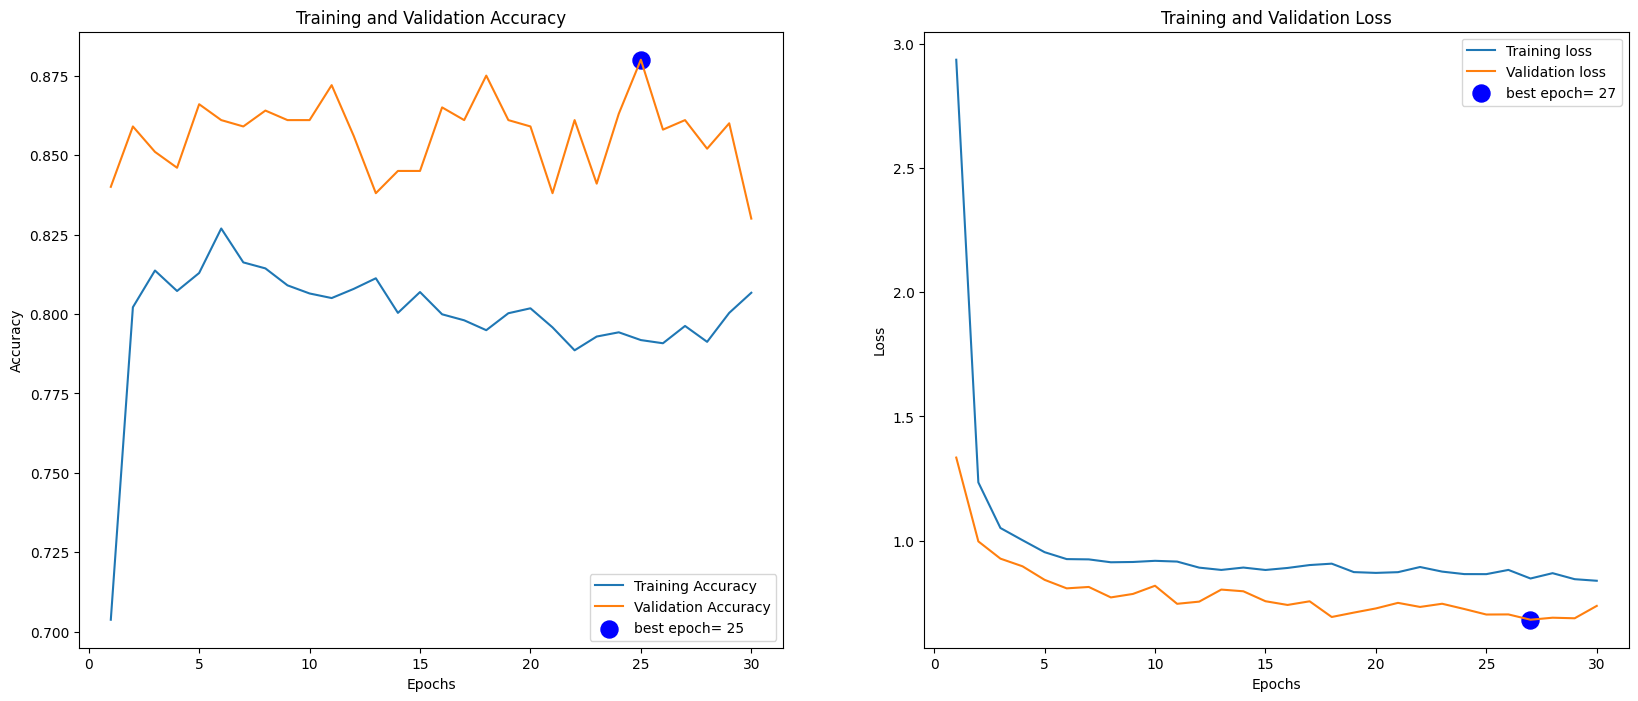

In [16]:
plot_training(history_mobilenet)

# Fine Tuning

## MobileNetV2

In [17]:
mobilenet.layers[0].trainable = True
mobilenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 2588490 (9.87 MB)
Trainable params: 255437

In [18]:
mobilenet.compile(
    optimizer=Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [19]:
fine_tune_epoch = 20

total_epochs =  initial_epochs + fine_tune_epoch

history_mobilenet_fine = mobilenet.fit(x=train_generator,
                         epochs=total_epochs,
                         initial_epoch=history_mobilenet.epoch[-1],
                         validation_data=validation_generator,
                         callbacks=[my_callbacks])

Epoch 30/50
225/225 [==============================] - 67s 181ms/step - loss: 1.4793 - accuracy: 0.5869 - val_loss: 1.2514 - val_accuracy: 0.6990
Epoch 31/50
225/225 [==============================] - 39s 172ms/step - loss: 0.9226 - accuracy: 0.7752 - val_loss: 1.2656 - val_accuracy: 0.7170
Epoch 32/50
225/225 [==============================] - 39s 171ms/step - loss: 0.7659 - accuracy: 0.8330 - val_loss: 1.2536 - val_accuracy: 0.7200
Epoch 33/50
225/225 [==============================] - 39s 171ms/step - loss: 0.6749 - accuracy: 0.8608 - val_loss: 1.1313 - val_accuracy: 0.7510
Epoch 34/50
225/225 [==============================] - 39s 174ms/step - loss: 0.6092 - accuracy: 0.8861 - val_loss: 1.0609 - val_accuracy: 0.7560
Epoch 35/50
225/225 [==============================] - 39s 171ms/step - loss: 0.5638 - accuracy: 0.9032 - val_loss: 0.9464 - val_accuracy: 0.7850
Epoch 36/50
225/225 [==============================] - 39s 171ms/step - loss: 0.5274 - accuracy: 0.9172 - val_loss: 0.8645 -

# Plot model before and after fine tuning

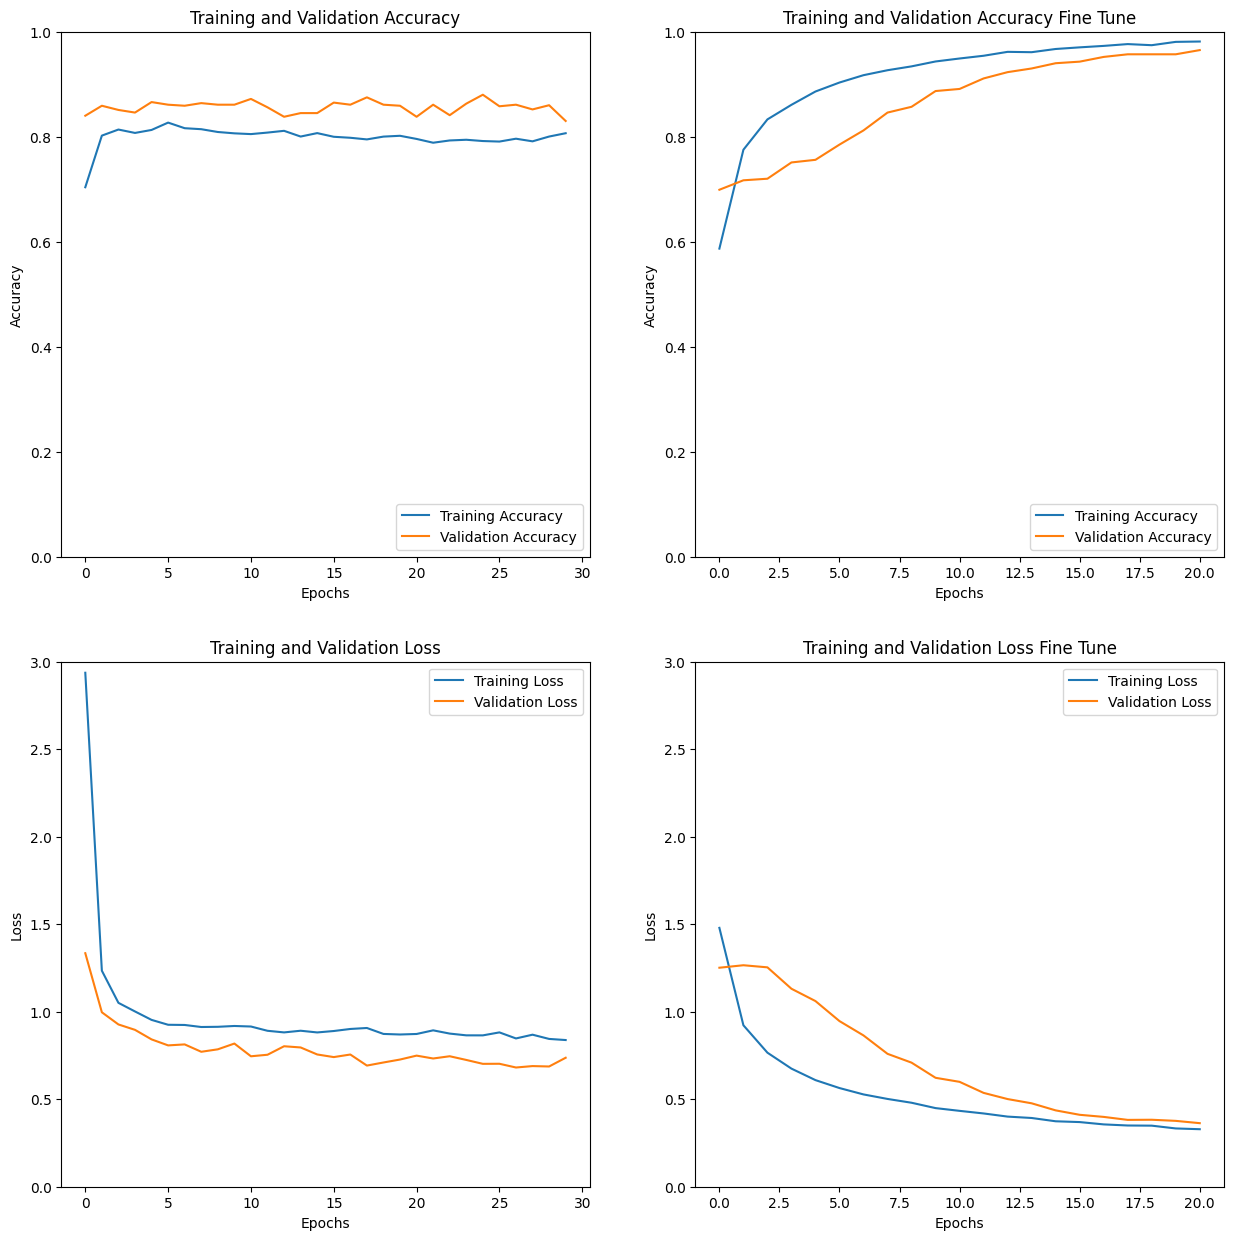

In [20]:
plt.figure(figsize= (15, 15))

plt.subplot(2, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label= 'Training Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylim([0, 1.0])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

plt.subplot(2, 2, 2)
plt.plot(history_mobilenet_fine.history['accuracy'], label= 'Training Accuracy')
plt.plot(history_mobilenet_fine.history['val_accuracy'], label= 'Validation Accuracy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Accuracy Fine Tune')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

plt.subplot(2, 2, 3)
plt.plot(history_mobilenet.history['loss'], label= 'Training Loss')
plt.plot(history_mobilenet.history['val_loss'], label= 'Validation Loss')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

plt.subplot(2, 2, 4)
plt.plot(history_mobilenet_fine.history['loss'], label= 'Training Loss')
plt.plot(history_mobilenet_fine.history['val_loss'], label= 'Validation Loss')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss Fine Tune')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

plt.tight_layout
plt.show()

# Evaluate model

In [21]:
ts_length = len(test_df)
steps = ts_length // test_batch
train_score = mobilenet.evaluate(train_generator, steps=steps, verbose= 1)
valid_score = mobilenet.evaluate(validation_generator, steps=steps, verbose= 1)
test_score = mobilenet.evaluate(test_generator, steps=steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

20/20 [==============================] - 4s 111ms/step - loss: 0.3631 - accuracy: 0.9600
Train Loss:  0.2521474361419678
Train Accuracy:  1.0
--------------------
Validation Loss:  0.34519001841545105
Validation Accuracy:  0.96875
--------------------
Test Loss:  0.3630850315093994
Test Accuracy:  0.9599999785423279


# Prediction

In [22]:
preds = mobilenet.predict(test_generator)
y_pred = [np.argmax(y) for y in preds]
print(y_pred)

20/20 [==============================] - 3s 120ms/step
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 8, 1, 1, 1, 1, 5, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 9, 9, 9, 9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

# Evaluation

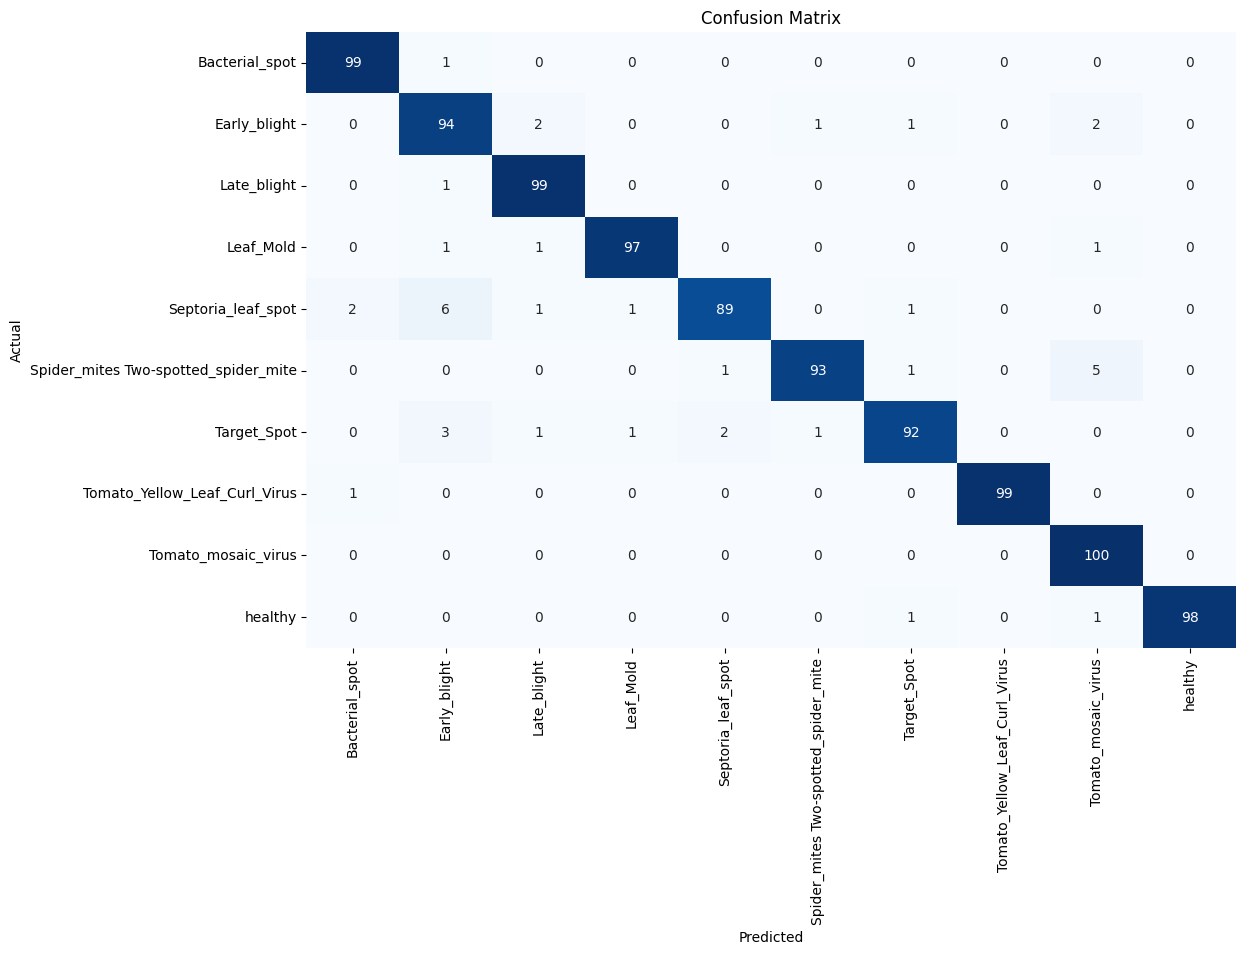


Classification Report:
----------------------
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.97      0.99      0.98       100
                        Early_blight       0.89      0.94      0.91       100
                         Late_blight       0.95      0.99      0.97       100
                           Leaf_Mold       0.98      0.97      0.97       100
                  Septoria_leaf_spot       0.97      0.89      0.93       100
Spider_mites Two-spotted_spider_mite       0.98      0.93      0.95       100
                         Target_Spot       0.96      0.92      0.94       100
       Tomato_Yellow_Leaf_Curl_Virus       1.00      0.99      0.99       100
                 Tomato_mosaic_virus       0.92      1.00      0.96       100
                             healthy       1.00      0.98      0.99       100

                            accuracy                           0.96      1000
               

In [23]:
def make_evaluation(test_gen, y_pred):
  classes = [label[9:] for label in list(test_gen.class_indices.keys())] # slice word "Tomato___"
  class_count = len(classes)
  cm = confusion_matrix(test_gen.classes, y_pred)

  plt.figure(figsize=(12, 8))
  sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
  plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
  plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()
  print("\nClassification Report:\n----------------------")
  print(classification_report(test_generator.classes, y_pred, target_names=classes))

make_evaluation(test_generator, y_pred)

# Save Model

# saved_model

In [24]:
save_path = 'saved_model/'
tf.saved_model.save(mobilenet, save_path)

In [25]:
!zip -r /content/saved_model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/saved_model.pb (deflated 91%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.index (deflated 77%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 8%)


## HDF5 Model

In [26]:
mobilenet.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## ONNX Model

In [27]:
!pip install onnxruntime
!pip install -U tf2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 35.7 MB/s eta 0:00:00


In [28]:
!python -m tf2onnx.convert --saved-model "saved_model" --output "model.onnx" --extra_opset ai.onnx.contrib:1

2024-01-31 05:30:05.686256: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 05:30:05.686313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 05:30:05.687630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 05:30:06.616339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2

## Pickle Model

In [29]:
import pickle
pickle.dump(mobilenet, open('model.pkl', 'wb'))

In [30]:
model_json = mobilenet.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)